# Combined plots - vector and scalar map

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [3]:
import psyplot.project as psy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import display, Video

from ipympl.backend_nbagg import Canvas
Canvas.header_visible.default_value = False

import warnings
warnings.filterwarnings("ignore", r"\s*The on_mappable_changed")
warnings.filterwarnings("ignore", r"\s*The input coordinates")
warnings.filterwarnings("ignore", r"\s*shading=")
warnings.filterwarnings("ignore", r"\s*\[Warning by")
warnings.filterwarnings("ignore", r"\s*ShapelyDeprecationWarning")

# To work with self-written modules, the paths of the modules directories have to be added
from pathlib import Path
import sys
icon_vis_dir = Path.cwd().parent
sys.path.insert(1,str(Path(icon_vis_dir,'data')))
sys.path.insert(1,str(Path(icon_vis_dir,'modules')))
sys.path.insert(1,str(icon_vis_dir / "modules" / "formatoptions"))

In [4]:
from get_data import get_example_data
from grid import combine_grid_information

In [5]:
# custom formatoptions import
import lakes
import borders
import rivers
import standardtitle

In [6]:
# import modules required for data interpolation
import interpolate

In [7]:
get_example_data()

 
Getting data from folder: grib
 
Getting data from folder: grids
 
Getting data from folder: nc


In [8]:
f_icon      = '../data/example_data/grib/lfff00000000_uv'
gridfile = '../data/example_data/grids/opr_r19b08'

In [9]:
# The icon file is in GRIB format, so we require the cfgrib engine to open. 
# If you look a the resulting xarray dataset you can see there is no grid data, so we need to merge it, see next cell.

ds_grib = psy.open_dataset(f_icon, engine='cfgrib', backend_kwargs={'indexpath': '', 'errors': 'ignore'})
ds_grib

<xarray.Dataset>
Dimensions:               (values: 44528, generalVerticalLayer: 80, depthBelowLandLayer: 8, depthBelowLand: 9, generalVertical: 81)
Coordinates: (12/20)
    number                int64 ...
    time                  datetime64[ns] ...
    step                  timedelta64[ns] ...
    surface               float64 ...
    valid_time            datetime64[ns] ...
  * generalVerticalLayer  (generalVerticalLayer) float64 1.0 2.0 ... 79.0 80.0
    ...                    ...
  * depthBelowLandLayer   (depthBelowLandLayer) float64 0.0 0.01 ... 2.43 7.29
    heightAboveGround     float64 ...
    lakeBottom            float64 ...
    entireLake            float64 ...
  * depthBelowLand        (depthBelowLand) float64 0.0 0.005 0.02 ... 4.86 14.58
  * generalVertical       (generalVertical) float64 1.0 2.0 3.0 ... 80.0 81.0
Dimensions without coordinates: values
Data variables: (12/70)
    snfalb                (values) float32 ...
    lhtfl                 (values) float32 ...
    nlwrf                 (values) float32 ...
    dlwrf                 (values) float32 ...
    ulwrf                 (values) float32 ...
    shtfl                 (values) float32 ...
    ...                    ...
    sd                    (values) float32 ...
    W_SO                  (depthBelowLandLayer, values) float32 ...
    W_SO_ICE              (depthBelowLandLayer, values) float32 ...
    wz                    (generalVertical, values) float32 ...
    THHR_RAD              (generalVerticalLayer, values) float32 ...
    SOHR_RAD              (generalVerticalLayer, values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich
    history:                 2022-04-07T14:10 GRIB to CDM+CF via cfgrib-0.9.9...

In [10]:
ds = combine_grid_information(f_icon, gridfile)
ds

<xarray.Dataset>
Dimensions:                  (time: 1, cell: 44528, generalVerticalLayer: 80, depthBelowLandLayer: 8, depthBelowLand: 9, generalVertical: 81, vertices: 3)
Coordinates: (12/24)
    number                   int64 ...
    forecast_reference_time  datetime64[ns] ...
    step                     timedelta64[ns] ...
    surface                  float64 ...
  * time                     (time) datetime64[ns] 2021-06-20T12:00:00
  * generalVerticalLayer     (generalVerticalLayer) float64 1.0 2.0 ... 80.0
    ...                       ...
  * depthBelowLand           (depthBelowLand) float64 0.0 0.005 ... 4.86 14.58
  * generalVertical          (generalVertical) float64 1.0 2.0 3.0 ... 80.0 81.0
    clon                     (cell) float32 0.1255 0.1258 ... 0.1451 0.145
    clat                     (cell) float32 0.7932 0.7933 ... 0.8173 0.8172
    clat_bnds                (cell, vertices) float32 0.7931 0.7932 ... 0.8171
    clon_bnds                (cell, vertices) float32 0.1253 0.1257 ... 0.1448
Dimensions without coordinates: cell, vertices
Data variables: (12/70)
    snfalb                   (time, cell) float32 0.1849 0.1858 ... 0.1823
    lhtfl                    (time, cell) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nlwrf                    (time, cell) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dlwrf                    (time, cell) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ulwrf                    (time, cell) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    shtfl                    (time, cell) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                       ...
    sd                       (time, cell) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    W_SO                     (time, depthBelowLandLayer, cell) float32 0.0 .....
    W_SO_ICE                 (time, depthBelowLandLayer, cell) float32 0.0 .....
    wz                       (time, generalVertical, cell) float32 0.001591 ....
    THHR_RAD                 (time, generalVerticalLayer, cell) float32 2.256...
    SOHR_RAD                 (time, generalVerticalLayer, cell) float32 0.0 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich
    history:                 2022-04-07T14:10 GRIB to CDM+CF via cfgrib-0.9.9...

In [11]:
# Dont plot with x and y gridlines
psy.rcParams["plotter.maps.xgrid"] = False
psy.rcParams["plotter.maps.ygrid"] = False

In [12]:
from psy_simple.plotters import CMap, Bounds
from psy_maps.plotters import Transform, MapPlot2D, LonLatBox, MapPlotter
from psyplot.plotter import Plotter
import psy_simple.plotters
import psy_maps.plotters
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Quiver plot

### Example with ICON data, before interpolation to regular grid

Result is mainly all black due to high density of arrows.

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


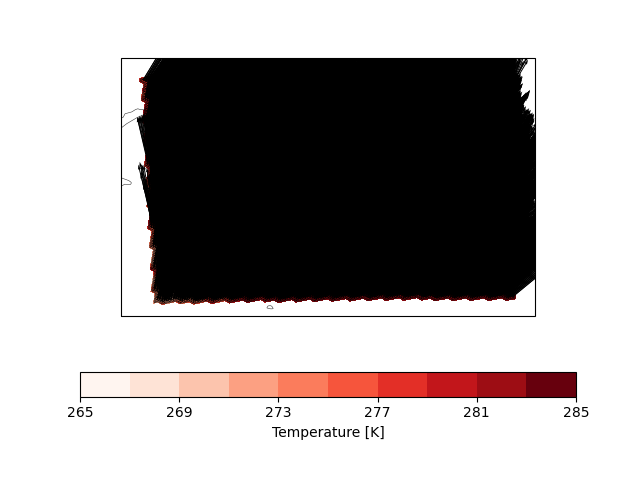

In [13]:
combinedplot_1 = psy.plot.mapcombined(ds,
            name=[['t',['u','v']]], 
            generalVerticalLayer=50, time=0, datagrid={'c': 'k', 'lw': 0.1}, xgrid=None, ygrid=None,
            borders=True, 
            cmap='Reds', 
            arrowsize=100, 
            vcbar='r',
            clabel='{desc}', 
            vclabel='Wind Speed [%(units)s]',
            #map_extent=[5.5, 11.0, 45.5, 48.0]
            )

In [14]:
# Zoom in to small area to see that data is plotted correctly, but the plot was not useful when viewing entire region.
combinedplot_1.update(map_extent=[7.8, 8.0, 47.0, 47.1])

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings.extend(multi_line_string)
/scratch/vcherkas/envs/psyplot/l

### Remap ICON wind data to Regular grid for plotting

ICON data can be too dense to plot wind barbs nicely, so to reduce the density of barbs, we can first interpolate the data to regular grid.

#### Fieldextra interpolation

In [48]:
output_file = interpolate.remap_ICON_to_regulargrid(
                                        data_file=f_icon,
                                        grid_file=gridfile,
                                        num_dates=ds.time.shape[0] # number of time steps in your data.
                                    )

print('Interpolated data stored at: '+ str(output_file))

ds_interp = psy.open_dataset(output_file)
ds_interp


Interpolated data stored at: /scratch-shared/meteoswiss/scratch/vcherkas/icon-vis/combinedplot/tmp/fieldextra/lfff00000000_uv_interpolated_regulargrid.nc


<xarray.Dataset>
Dimensions:         (time: 1, x_1: 101, y_1: 101, z_1: 80, zbound: 2, epsd_1: 1)
Coordinates:
  * time            (time) datetime64[ns] 2021-06-20T12:00:00
  * x_1             (x_1) float32 5.5 5.555 5.61 5.665 ... 10.89 10.94 11.0
  * y_1             (y_1) float32 45.5 45.53 45.55 45.58 ... 47.95 47.97 48.0
    lon_1           (y_1, x_1) float32 ...
    lat_1           (y_1, x_1) float32 ...
    grid_mapping_1  |S1 ...
  * z_1             (z_1) float32 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
    z_bnds_1        (z_1, zbound) float32 ...
  * epsd_1          (epsd_1) int32 1
Dimensions without coordinates: zbound
Data variables:
    U               (time, epsd_1, z_1, y_1, x_1) float32 ...
    V               (time, epsd_1, z_1, y_1, x_1) float32 ...
Attributes:
    Conventions:     CF-1.6
    ConventionsURL:  http://cfconventions.org/cf-conventions/v1.6.0/cf-conven...
    institution:     MeteoSwiss (NMC Switzerland)
    source:          model: icon-1e, production_status: test_operational, ver...
    history:         Produced by fieldextra version v14.1.0d (dev_test_passed...

In [49]:
ds_interp.U.encoding['coordinates'] = 'x_1 y_1'
ds_interp.V.encoding['coordinates'] = 'x_1 y_1'

#### Note
The remap_ICON_to_regulargrid module has only been tested/written for netcdf, with U,V variables, and creating a regular grid region over Switzerland). If the namelist generation doesnt work for your data, you can alternatively modify the NAMELIST_ICON_REG_REMAP file and run fieldextra yourself. For example on Tsa, in your shell you can run:

`/project/s83c/fieldextra/tsa/bin/fieldextra_gnu_opt_omp NAMELIST_ICON_REG_REMAP` 

You can define the output location and use that as input to psyplot, as in next step.

In [50]:
import psyplot.data as psyd

uv = ds_interp.psy.create_list(name=[["U", "V"]], time=0, z=79, squeeze=True)[0] # regular grid wind data
temp = ds.psy.create_list(name="t", t=0, z=79)[0]  # icon grid temperature data


In [51]:
data = psyd.InteractiveList([temp, uv])

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


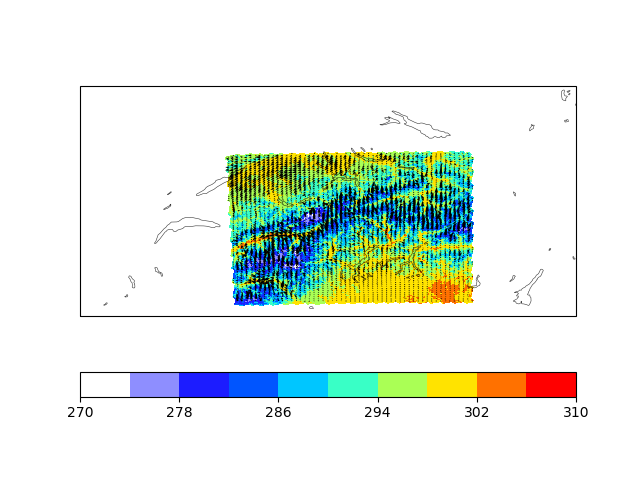

In [52]:
plotter = psy.plot.mapcombined.plotter_cls(data)

In [53]:
from psyplot.project import Project
project = Project([data])

In [54]:
project.update(
    borders=True,
    cmap='Reds',
    density=0.4, 
    arrowsize=200,
    map_extent=[6.9, 10.2, 45.3, 47.5],
   vplot='quiver',
clabel='{desc}',
title='Combined Scalar and Vector Plot after Interpolation')

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/

In [ ]:
plt.ioff()

with project as sp:
    sp.export('combined_plot.png')

plt.ion()